# **Fazendo um modelo de predição se os clientes enviados ao banco irão ser convertidos ou não.**



---

---





Instalando bibliotecas e verificando o Dataset
Carrega pacotes

In [ ]:
## Importa pacotes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns
import scipy
import sklearn
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#vamos importar os algoritmos a serem explorados
from sklearn.metrics import f1_score,accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

#from sklearn.svm import svm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA


import xgboost as xgb
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")



#import janitor

Lendo os dados da empresa:

In [ ]:
df = pd.read_csv('/content/DadosEmpresaXYZ.csv')

df.head()



,sessão_data_hora,estado,mensagem_estado,receita,affiliate_unique_1,pais,região,cidade,navegador,marca_dispositivo,modelo_de_dispositivo,genero,login_google,login_facebook,login_senha,negativado,negativado_data,restricao_1,restricao_1_data,primeiro_cartao,primeiro_cartao_data,renda,nascimento,telefone_verificado,email_verificado,tipo_ocupacao,uf,score,score_data,score_debito,score_consumidor_positivo
0,2020-08-31 2:34:57,approved,Tracking cookie de cliente,NÃO,5f4c7de4340fc00007e8c284,Brazil,Sao Paulo,Sao Paulo,Android,Motorola,Moto G8 Play,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-02 17:30:27,rejected,Duplicar Conversão por Transação ID,NÃO,5f4ff2c4f83bd900083ea67c,Brazil,Sao Paulo,Sao Paulo,Android,Motorola,Moto E6 Plus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-02 17:30:27,rejected,Duplicar Conversão por Transação ID,NÃO,5f4ff2c4f83bd900083ea67c,Brazil,Sao Paulo,Sao Paulo,Android,Motorola,Moto E6 Plus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-02 20:29:50,rejected,Duplicar Conversão por Transação ID,NÃO,5f501cd0f6a49900080eba08,Brazil,Santa Catarina,Jaragua Do Sul,Android,Samsung,SM-J700M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-02 20:29:50,rejected,Duplicar Conversão por Transação ID,NÃO,5f501cd0f6a49900080eba08,Brazil,Santa Catarina,Jaragua Do Sul,Android,Samsung,SM-J700M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Primeira análise des dados:**



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35855 entries, 0 to 35854
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sessão_data_hora           35855 non-null  object 
 1   estado                     35855 non-null  object 
 2   mensagem_estado            35855 non-null  object 
 3   receita                    35855 non-null  object 
 4   affiliate_unique_1         35855 non-null  object 
 5   pais                       35855 non-null  object 
 6   região                     35855 non-null  object 
 7   cidade                     35855 non-null  object 
 8   navegador                  35843 non-null  object 
 9   marca_dispositivo          35854 non-null  object 
 10  modelo_de_dispositivo      35850 non-null  object 
 11  genero                     2055 non-null   object 
 12  login_google               6350 non-null   object 
 13  login_facebook             6350 non-null   obj

In [ ]:
df.nunique()

sessão_data_hora             21582
estado                           3
mensagem_estado                  3
receita                          2
affiliate_unique_1           21830
pais                            17
região                          66
cidade                        1879
navegador                        6
marca_dispositivo               40
modelo_de_dispositivo          495
genero                           3
login_google                     1
login_facebook                   1
login_senha                      1
negativado                       4
negativado_data               1730
restricao_1                      2
restricao_1_data              1885
primeiro_cartao                  2
primeiro_cartao_data           150
renda                          260
nascimento                    1351
telefone_verificado              2
email_verificado                 2
tipo_ocupacao                    9
uf                              51
score                          335
score_data          

**Retirando campos que tem valor único e alguns de data ( que já tem um correspondente categórico depois). **

In [ ]:
df.drop(labels=['sessão_data_hora', 'região', 'estado', 'cidade', 'navegador', 'email_verificado', 'telefone_verificado', 'marca_dispositivo', 'mensagem_estado', 'modelo_de_dispositivo', 'login_google', 'login_facebook', 'login_senha', 'pais', 'negativado_data', 'primeiro_cartao_data', 'restricao_1_data', 'score_data'], axis=1, inplace=True )


Eliminando itens duplicados:

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.fillna('NÃO', inplace=True)

- Padronizando valores booleanos para 0 e 1 para depois conseguirmos transformar em categóricos.
- Agrupando estados por região
- Transformando dados de data de nascimento para calcular idade


In [ ]:
df.apply(pd.Series.replace, to_replace='NÃO', value=0, inplace=True)
df.apply(pd.Series.replace, to_replace='SIM', value=1, inplace=True)
df.apply(pd.Series.replace, to_replace='no', value=0, inplace=True)
df.apply(pd.Series.replace, to_replace='yes', value=1, inplace=True)
df.apply(pd.Series.replace, to_replace='yes-but-solving', value=1, inplace=True)
df.apply(pd.Series.replace, to_replace='yes-solved', value=1, inplace=True)



def regioes(row):
    if str(row).upper() in ('GO', 'MS', 'MT', 'DF'):
      return 'centro'
    elif str(row).upper() in ('AC', 'AM', 'PA', 'RN', 'RO' , 'TO') :
      return 'norte'
    elif str(row).upper() in ('AL', 'BA', 'CE', 'MA', 'PI' , 'PE', 'PB', 'RN', 'SE' ) :
      return 'nordeste'
    elif str(row).upper() in ('RS', 'PR', 'SC' ):
      return 'sul'
    elif str(row).upper() in ('RJ', 'SP', 'ES', 'MG' ):
      return 'sudeste'
    else:
      return 'outro'

df['regioes'] = df['uf'].apply(regioes)


def transgenero(row):
    if str(row).upper() not in ('F', 'M'):
      return 'O'
    else:
      return str(row).upper()

df['genero'] = df['genero'].apply(transgenero)

In [ ]:
print('{:.2f} % da coluna ocupação está vazia'.format((df['tipo_ocupacao'] == 0).sum() / len(df) * 100))
print('{:.2f} % da coluna uf está vazia'.format((df['uf'] == 0).sum() / len(df) * 100))

#(df['uf'] == '0').sum() / len(df)

94.56 % da coluna ocupação está vazia
94.70 % da coluna uf está vazia


In [ ]:
# Verificando percentual de itens com valor 0:
df['uf'].unique()



array([0, 'PA', 'rj', 'sp', 'ba', 'sc', 'RJ', 'PE', 'pi', 'PB', 'mg',
       'SP', 'CE', 'ce', 'pb', 'GO', 'MG', 'ms', 'MT', 'pr', 'al', 'pe',
       'BA', 'rn', 'MS', 'PI', 'RS', 'es', 'PR', 'go', 'SC', 'rs', 'ma',
       'RN', 'ES', 'pa', 'mt', 'ac', 'df', 'AC', 'MA', 'DF', 'AP', 'AL',
       'SE', 'ro', 'se', 'ap', 'am', 'AM', 'TO', 'RO'], dtype=object)

In [ ]:
#df.astype({'receita': 'category', 'genero' : 'category',  'negativado': 'category', 'restricao_1': 'category',
#'primeiro_cartao': 'category', 'telefone_verificado': 'category', 'email_verificado' : 'category', 
#'score_debito' : 'category', 'score_consumidor_positivo' : 'category', 'estado': 'category'})

df.receita = df.receita.astype('category')
df['genero'] = df.genero.astype('category')
df['negativado'] = df.negativado.astype('category')
df['restricao_1'] = df.restricao_1.astype('category')
df['primeiro_cartao'] = df.primeiro_cartao.astype('category')
df['score_debito'] = df.score_debito.astype('category')
df['score_consumidor_positivo'] = df.score_consumidor_positivo.astype('category')
df['nascimento'] = df.nascimento.astype('string')



In [ ]:
#Verificando datas de nascimento vazias e atualizando resultado
from datetime import datetime

func = lambda row: str(datetime.now()) if row == '0' else row

df['nascimento'] = df['nascimento'].apply(func)

In [ ]:
from datetime import datetime

#type(df['nascimento'])
df['Date_Converted'] = df['nascimento'].apply(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'))
now = pd.Timestamp('now')
#df['dob'] = pd.to_datetime(df['Date_Converted'], format='%m%d%y')    # 1
df['Date_Converted'] = df['Date_Converted'].where(df['Date_Converted'] < now, df['Date_Converted'] -  np.timedelta64(100, 'Y'))   # 2
df['age'] = (now - df['Date_Converted']).astype('<m8[Y]')    # 3



Criando variáveis dummies:

In [ ]:
df = pd.get_dummies(df, columns = ['tipo_ocupacao'] , dummy_na=False)
df = pd.get_dummies(df, columns = ['regioes'] , dummy_na=False)
df = pd.get_dummies(df, columns = ['genero'] , dummy_na=False)



Agora podemos excluir a data de nascimento, o date_converted e o uf, pois temos tudo calculado em categórica.

In [ ]:
df.drop(labels=['nascimento', 'Date_Converted', 'affiliate_unique_1', 'uf'], axis=1, inplace=True )

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21892 entries, 0 to 35853
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   receita                                         21892 non-null  category
 1   negativado                                      21892 non-null  category
 2   restricao_1                                     21892 non-null  category
 3   primeiro_cartao                                 21892 non-null  category
 4   renda                                           21892 non-null  float64 
 5   score                                           21892 non-null  float64 
 6   score_debito                                    21892 non-null  category
 7   score_consumidor_positivo                       21892 non-null  category
 8   age                                             21892 non-null  float64 
 9   tipo_ocupacao_0             

In [ ]:
df['negativado'].unique()

[0, 1]
Categories (2, int64): [0, 1]

Class 0: 21286
Class 1: 606
Proportion: 35.13 :1


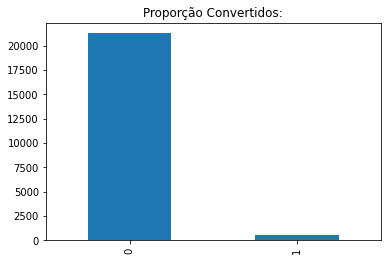

In [ ]:
target_count = df.receita.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ':1')

target_count.plot(kind='bar', title='Proporção Convertidos:')


Ao verificar que a proporção de convertidos para não convertidos é extremamente desbalanceada, vamos fazer um oversample para que nosso modelo consiga identificar corretamente os 2 grupos.

In [ ]:
#Fazendo a separação entre X e Y

X = df.drop(columns= ['receita'])
y = df['receita']


In [ ]:
print('Tamanho dataset original: %s' % Counter(y))
ros = RandomOverSampler(random_state=42)

X_ros, y_ros = ros.fit_sample(X,y)

print(X_ros.shape[0] - X.shape[0], 'novos pontos de amostras.')

print('Tamanho do dataset aumentado: %s' % Counter(y_ros))

Tamanho dataset original: Counter({0: 21286, 1: 606})
20680 novos pontos de amostras.
Tamanho do dataset aumentado: Counter({0: 21286, 1: 21286})


Vamos comparar a Acurácia usando XGBoost do Original com o aumentado.

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.2)

In [ ]:
len(X_train), len(X_test)

(34057, 8515)

Após transformar todas as variáveis em numéricas ou categóricas. Vamos treinar o modelo pelo XGBoost:

In [ ]:
reg = xgb.XGBClassifier(missing=None, seed=42)
reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric = 'aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.525527
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.525923
[2]	validation_0-aucpr:0.525632
[3]	validation_0-aucpr:0.526372
[4]	validation_0-aucpr:0.526106
[5]	validation_0-aucpr:0.526935
[6]	validation_0-aucpr:0.533029
[7]	validation_0-aucpr:0.533029
[8]	validation_0-aucpr:0.550918
[9]	validation_0-aucpr:0.550944
[10]	validation_0-aucpr:0.552112
[11]	validation_0-aucpr:0.552592
[12]	validation_0-aucpr:0.553772
[13]	validation_0-aucpr:0.554582
[14]	validation_0-aucpr:0.554176
[15]	validation_0-aucpr:0.555333
[16]	validation_0-aucpr:0.556313
[17]	validation_0-aucpr:0.557057
[18]	validation_0-aucpr:0.564016
[19]	validation_0-aucpr:0.565203
[20]	validation_0-aucpr:0.565345
[21]	validation_0-aucpr:0.565269
[22]	validation_0-aucpr:0.562523
[23]	validation_0-aucpr:0.56312
[24]	validation_0-aucpr:0.563516
[25]	validation_0-aucpr:0.566144
[26]	validation_0-aucpr:0.567467
[27]	validation_0-aucpr:0.567469
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

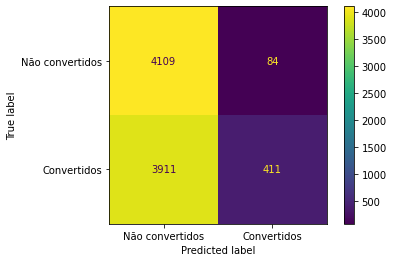

In [ ]:
plot_confusion_matrix(reg, X_test, y_test, values_format='d', display_labels=['Não convertidos', 'Convertidos'])


In [ ]:
y_pred = reg.predict(X_test)


In [ ]:
#Precision 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))
#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

Precision 0.83
Recall 0.10
F1 Score 0.17
Specificity 0.98


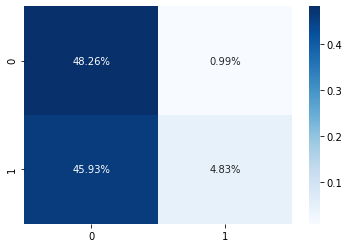

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Tunando Hiperparâmetros para ver se melhora a eficácia do modelo ( 1. Round)

In [ ]:
#param_grid = { 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01, 0.05], 'gamma': [0, 0.25, 1.0],
#              'reg_lambda': [0, 1.0, 10.0], 'scale_pos_weight': [1, 3, 5]}

#optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_by_tree=0.5),
#                            param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
#optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)

#print(optimal_params.best_params_)


2. Round:

In [ ]:
#param_grid = { 'max_depth': [5, 6, 7], 'learning_rate': [0.1, 0.5, 1], 'gamma': [0.25],
#              'reg_lambda': [0], 'scale_pos_weight': [5, 7, 9]}

#optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_by_tree=0.5),
#                            param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
#optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)


#print(optimal_params.best_params_)

3. Round

In [ ]:
#param_grid = { 'max_depth': [7, 8, 9], 'learning_rate': [0.5], 'gamma': [0.25],
#              'reg_lambda': [0], 'scale_pos_weight': [7]}

#optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_by_tree=0.5),
#                            param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
#optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)


#print(optimal_params.best_params_)

4. Round

In [ ]:
#param_grid = { 'max_depth': [9, 10, 11], 'learning_rate': [0.5], 'gamma': [0.25],
#              'reg_lambda': [0], 'scale_pos_weight': [7]}

#optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_by_tree=0.5),
#                            param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
#optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)


#print(optimal_params.best_params_)

Veja que os resultados acima deram o parâmetro do meio e o max depth parou de pedir aumentos, então iremos usá-los para testar se o tunning melhore a eficácia.

Para prevenir overfitting estamos usando só 90% da nossa amostra.

In [ ]:
reg = xgb.XGBClassifier(seed=42, 
                        objective='binary:logistic',
                        gamma=0.25,
                        learn_rate=0.5,
                        max_depth=9,
                        reg_lambda=0,
                        scale_pos_weight=7,
                        subsample=0.9,
                        colsample_bytree=0.5)
reg.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric = 'aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.564372
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.579174
[2]	validation_0-aucpr:0.584845
[3]	validation_0-aucpr:0.590685
[4]	validation_0-aucpr:0.593356
[5]	validation_0-aucpr:0.594075
[6]	validation_0-aucpr:0.598642
[7]	validation_0-aucpr:0.600193
[8]	validation_0-aucpr:0.600183
[9]	validation_0-aucpr:0.601468
[10]	validation_0-aucpr:0.602397
[11]	validation_0-aucpr:0.603016
[12]	validation_0-aucpr:0.6028
[13]	validation_0-aucpr:0.60361
[14]	validation_0-aucpr:0.605221
[15]	validation_0-aucpr:0.606058
[16]	validation_0-aucpr:0.606012
[17]	validation_0-aucpr:0.607197
[18]	validation_0-aucpr:0.612002
[19]	validation_0-aucpr:0.609952
[20]	validation_0-aucpr:0.609776
[21]	validation_0-aucpr:0.609742
[22]	validation_0-aucpr:0.609268
[23]	validation_0-aucpr:0.609679
[24]	validation_0-aucpr:0.609888
[25]	validation_0-aucpr:0.609808
[26]	validation_0-aucpr:0.610011
[27]	validation_0-aucpr:0.610468
[28]	validation_0-aucpr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learn_rate=0.5, learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=7, seed=42,
              silent=None, subsample=0.9, verbosity=1)

Parece que houve uma melhora, antes o nosso modelo atingia no máximo 0.57 agora estamos com 0.60! Vamos se a matriz de confusão melhorou:

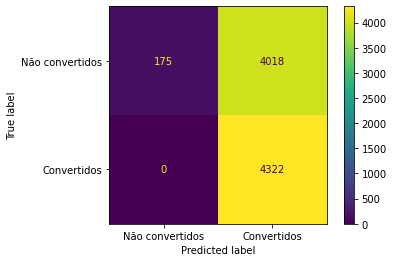

In [ ]:
plot_confusion_matrix(reg, X_test, y_test, values_format='d', display_labels=['Não convertidos', 'Convertidos'])


In [ ]:
y_pred = reg.predict(X_test)

#Precision 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))
#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))


Precision 0.52
Recall 1.00
F1 Score 0.68
Specificity 0.04


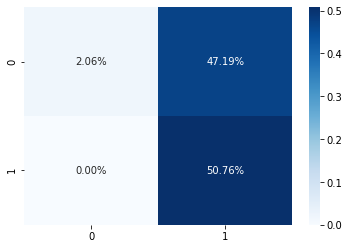

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Comparando com o anterior: 
Precision 0.78
Recall 0.08
F1 Score 0.14
Specificity 0.98

Percebe-se:
- Piora na precisão, Recall de 100%, melhora no F1 Score e piora no Specificity

Vamos tentar outro modelo? Que tal um mais simples como SVM?

In [ ]:
# Para o SVM é bom termos todos eles escalados.

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [ ]:
clf_svm = sklearn.svm.SVC(random_state=42)

clf_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

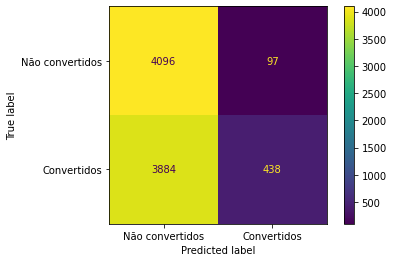

In [ ]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=['Não convertidos', 'Convertidos'])


Precision 0.82
Recall 0.10
F1 Score 0.18
Specificity 0.98


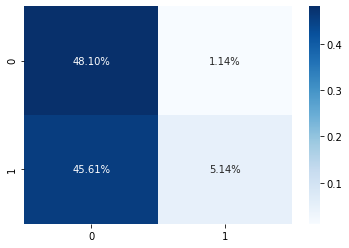

In [ ]:
y_pred = clf_svm.predict(X_test_scaled)

#Precision 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))
#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')



Performance horrível no SVM também... Vamos ver se tunando os parâmetros melhoramos este resultado.

In [ ]:
#param_grid = [ 
# {   'C': [0.5, 1, 10, 100],
#    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
#    'kernel': ['rbf']}
#]

#optimal_params = GridSearchCV(
#    sklearn.svm.SVC(),
#    param_grid,
#    cv=5,
#    scoring='f1'
#)

#optimal_params.fit(X_train_scaled, y_train)
#print(optimal_params.best_params_)

Esse tunning demorou mais de 3 horas!

In [ ]:
clf_svm = sklearn.svm.SVC(random_state=42, C=100, gamma = 1)

clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

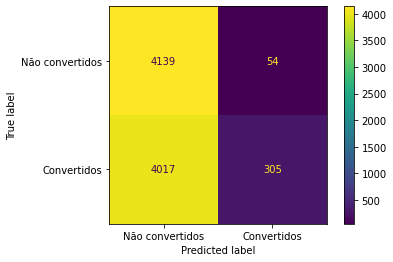

In [ ]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=['Não convertidos', 'Convertidos'])

Precision 0.85
Recall 0.07
F1 Score 0.13
Specificity 0.99


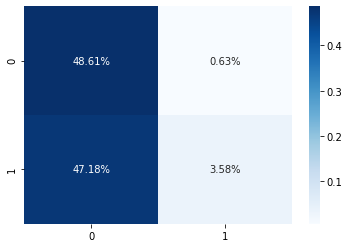

In [ ]:
y_pred = clf_svm.predict(X_test_scaled)

#Precision 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))
#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Comparando com o resultado anterior:

Precision 0.80
Recall 0.10
F1 Score 0.18
Specificity 0.97

Percebemos apenas uma ligeira melhora na precisão, de resto, piorou o resultado!



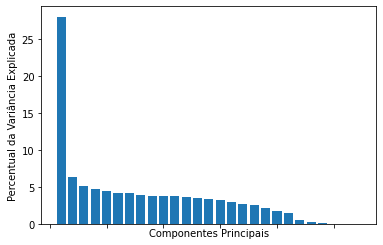

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)

labels = [str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)

plt.tick_params( 
    axis='x',
    which='both',
    top=False,
    labelbottom=False
)

plt.ylabel('Percentual da Variância Explicada')
plt.xlabel('Componentes Principais')
plt.show()


Parece que só a primeira variável explica a maior parte do resultado. Vamos ver como vai ficar.

In [ ]:
train_pc1_words = X_train_pca[:,0]
train_pc2_words = X_train_pca[:,1]


pca_train_scaled = scale(np.column_stack((train_pc1_words, train_pc2_words)))

param_grid = [{ 'C': [1, 10, 100, 1000],
              'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'] },
              ]

optimal_params = GridSearchCV(
    sklearn.svm.SVC(),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)




In [ ]:
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


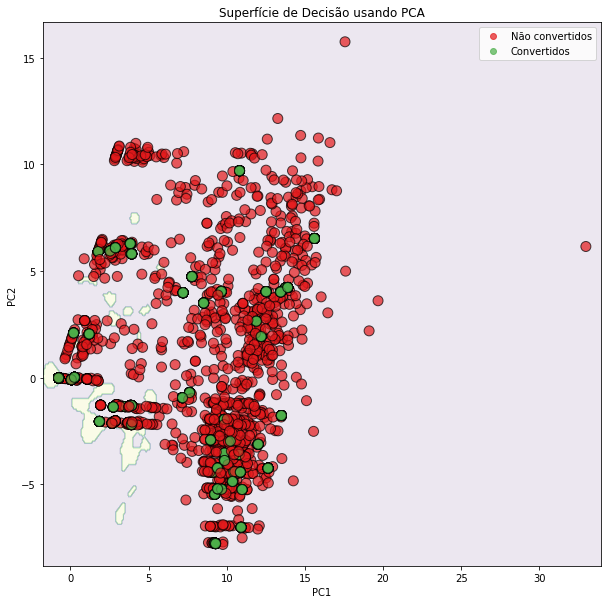

In [ ]:
clf_svm = sklearn.svm.SVC(random_state = 42, C=1000, gamma=1)
clf_svm.fit(pca_train_scaled, y_train)

# Transformar the database test com o PCA
X_test_pca = pca.transform(X_train_scaled)
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]

x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx,yy, Z, alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train,
                     cmap=cmap,
                     s=100,
                     edgecolors='k', 
                     alpha=0.7)
legend= ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc="upper right")
legend.get_texts()[0].set_text("Não convertidos")
legend.get_texts()[1].set_text("Convertidos")

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Superfície de Decisão usando PCA')
plt.show()




- Os pontos são dados no DataSet de Treino e são coloridos por suas classificações;
- Pontos claros foram previstos pelo modelo;
- Como os dados são feitos a partir dos dados de treino e não de teste, não vão bater com a matriz de confusão.
- Infelizmente não é um bom modelo para trabalhar com estes dados.